### Genes with SRP

In [ ]:
import time
import timeit
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from tqdm import tqdm
from scipy.stats import mannwhitneyu
import scipy.stats as stats

# transparent background
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),  
    "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),  
})

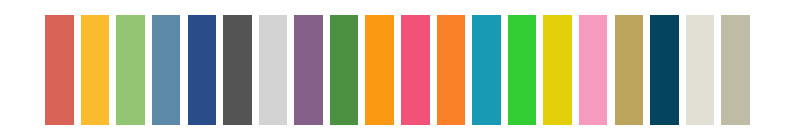

In [2]:
# define colors
purple = '#856088'
pink = '#F25278'
red = '#d96256'
lightgreen = '#93c572'
darkgreen = '#4c9141'
lightblue = '#5d8aa8'
darkblue = '#284d88'
white = '#fafafa'
lightgray = '#d3d3d3'
darkgray ='#545454'
lightorange = '#fabc2e'
darkorange = '#fb9912'
lightyellow = '#e4d00a'
lightgreen2 = '#32CD32'
lightblue2 = '#189AB4'
darkblue2 = '#05445E'
lightpink = '#F79AC0'
darkorange2 = '#FA8128'
darkyellow = '#BDA55D'
lightgray2 = '#E2E0D4'
lightgray3 = '#BFBBA4'

colors = [
    red, lightorange, lightgreen, lightblue, darkblue, 
    darkgray, lightgray, purple, darkgreen, darkorange,
    pink, darkorange2, lightblue2, lightgreen2, lightyellow,
    lightpink, darkyellow, darkblue2, lightgray2, lightgray3
]

plt.figure(figsize=(10, 1.5))
plt.bar(range(len(colors)), height=1, color=colors)
__ = plt.axis('off')

#### load data

In [3]:
# load processed seqscope SRP data
path = '../validation5_SRP/output/seqscope_SRP_dict.pkl'
pickle_dict = pd.read_pickle(path)
SRP_df = pickle_dict['seqscope_SRP_df'] # score>=0.95 are kept
srp_list = SRP_df.gene.tolist()
SRP_df.head(3)

,gene,origin,feature,start,end,score,dot1,dot2,evidence
5,Pkhd1,DeepSig,Signal peptide,1,18,1.00,.,.,evidence=ECO:0000256
8,Col19a1,DeepSig,Signal peptide,1,23,0.99,.,.,evidence=ECO:0000256
12,Col5a2,DeepSig,Signal peptide,1,26,1.00,.,.,evidence=ECO:0000256


In [4]:
# load ella seqscope results
fn = '../ella/output_ella/ella_seqscope.pkl'
res_dict = pd.read_pickle(fn)
types_list = res_dict['types_list']
genes_dict = res_dict['genes_dict']
cells_dict = res_dict['cells_dict']
p_fdr_dict = res_dict['p_fdr_dict']
score_dict = res_dict['score_dict']
lam_dict = res_dict['lam_dict']
label_dict = res_dict['label_dict']
del res_dict

In [5]:
# #SRP avl in gene lists
srp_dict = {}
for t in types_list:
    gl_t = genes_dict[t]
    srp_dict[t] = list(set(gl_t).intersection(srp_list))
    print(f'#SRP avl in {t} {len(srp_dict[t])}')

#SRP avl in H1 201
#SRP avl in H2 201
#SRP avl in TD1 124
#SRP avl in TD2 203


In [6]:
# get pv, scores, labels of SRP avl genes
# get the pv_fdr and scores of SRP avl
srp_gene_list_dict = {}
srp_pv_fdr_dict = {}
srp_scores_dict = {}
srp_labels_dict = {}
for t in types_list:
    srp_t = np.array(srp_dict[t])
    gl_t = np.array(genes_dict[t])
    pv_fdr_t = np.array(p_fdr_dict[t])
    scores_t = np.array(score_dict[t])
    labels_t = np.array(label_dict[t])
    srp_pv_fdr_t = []
    srp_scores_t = []
    srp_labels_t = []
    for ig, g in enumerate(srp_t):
        idx = np.where(gl_t == g)[0][0]
        srp_pv_fdr_t.append(pv_fdr_t[idx])
        srp_scores_t.append(scores_t[idx])
        srp_labels_t.append(labels_t[idx])
    srp_pv_fdr_dict[t] = srp_pv_fdr_t
    srp_scores_dict[t] = srp_scores_t
    srp_labels_dict[t] = srp_labels_t
    nsig_ = np.sum(np.array(srp_pv_fdr_t)<=0.05)
    print(f'#sig SRP in {t} {nsig_}')

#sig SRP in H1 35
#sig SRP in H2 32
#sig SRP in TD1 16
#sig SRP in TD2 33


#### all types together

In [40]:
# cluster 1-4 vs 0
srp_label_all = np.concatenate([lst for lst in srp_labels_dict.values()])
label_all = np.concatenate([lst for lst in label_dict.values()])

# number of sig SRP with label=1-4
n11 = np.sum(srp_label_all>0)
# number of sig SRP with label=0
n12 = np.sum(srp_label_all==0)
# number of sig non-SRP with label=1-4
n21 = np.sum(label_all>0) - n11
# number of sig non-SRP with label=0
n22 = np.sum(label_all==0) - n12

#       label=1-4  label=-1,0
data = [[n11,      n12], # SRP
        [n21,      n22]] # non-SRP

# fisher test
odd_ratio, p_value1 = stats.fisher_exact(data)
print(f'p={p_value1}')
print(f'1-4 SRP={n11/(n11+n21)*100:.2f}%')
print(f'0 SRP={n12/(n12+n22)*100:.2f}%')

p12 = [p_value1]

p=1.719548528184856e-05
1-4 SRP=40.57%
0 SRP=16.83%


In [41]:
# cluster 1-4 vs all others
# number of sig SRP with label=1-4
n11 = np.sum(srp_label_all>0)
# number of sig SRP with label=-1,0
n12 = np.sum(srp_label_all<=0)
# number of sig non-SRP with label=1-4
n21 = np.sum(label_all>0) - n11
# number of sig non-SRP with label=-1,0
n22 = np.sum(label_all<=0) - n12

#       label=1-4  label=-1,0
data = [[n11,      n12], # SRP
        [n21,      n22]] # non-SRP

# fisher test
odd_ratio, p_value2 = stats.fisher_exact(data)
print(f'p={p_value2}')
print(f'1-4 SRP={n11/(n11+n21)*100:.2f}%')
print(f'-1,0 SRP={n12/(n12+n22)*100:.2f}%')

p13 = [p_value2]

p=9.405690221950929e-21
1-4 SRP=40.57%
-1,0 SRP=14.95%


In [42]:
def sig_symb(p_value):
    if p_value <= 0.001:
        sig_symbol = '***'
    elif p_value <= 0.01:
        sig_symbol = '**'
    elif p_value <= 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ''
    return sig_symbol

[0.16831683 0.4057377  0.1633777 ]


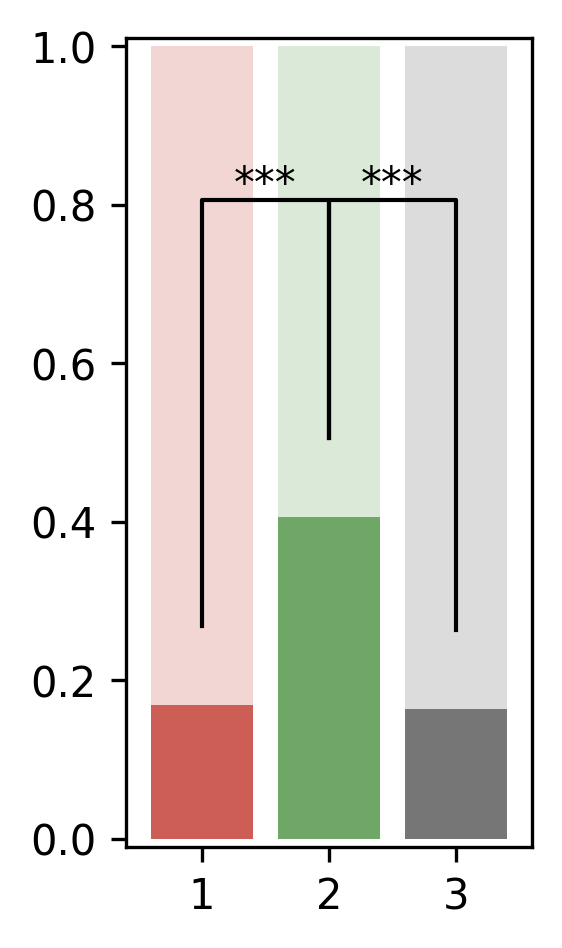

In [62]:
# bar plot of all clusters

bar_width = 0.8
colors = [red, darkgreen, darkgray]

nr = 1
nc = 1
ss_nr = 3.5
ss_nc = 7/4
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr, nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

bar_pos = np.array([1,2,3])
srp_proportion = []
# cluster 1
srp_proportion.append(np.sum(srp_label_all==0)/np.sum(label_all==0))
# cluster 2-5
srp_proportion.append(np.sum(np.logical_and(srp_label_all!=0,srp_label_all!=-1))/np.sum(np.logical_and(label_all!=0, label_all!=-1)))
# other than cluster 1
srp_proportion.append(np.sum(srp_label_all!=0)/np.sum(label_all!=0))
srp_proportion = np.array(srp_proportion)
print(srp_proportion)
nonsrp_proportion = 1-srp_proportion

bars_low = ax.bar(bar_pos, srp_proportion, 
                  width = bar_width,
                  color=colors, alpha=0.8)
bars_upper = ax.bar(bar_pos, nonsrp_proportion, 
                    width = bar_width,
                    bottom=srp_proportion, color=colors, alpha=0.2)

ax.set_xlim(0.4,3.6)
ax.set_ylim(-0.01, 1.01)
ax.set_xticks(bar_pos, bar_pos)

# pv
hgap_big = 0.4
hgap_small = 0.02
hgap_txt = 0.1
for j, p in enumerate(p12[:]):
    x1 = 1
    x2 = x1+1
    bar1_max = srp_proportion[0]
    bar2_max = srp_proportion[1]
    bar12_max = np.maximum(bar1_max, bar2_max)
    
    if p<=0.05:
        ax.plot(
            [x1, x1, x2, x2],
            [bar1_max+hgap_txt, bar12_max+hgap_big, bar12_max+hgap_big, bar2_max+hgap_txt],
            lw=1, 
            color='black'
        )

        ax.text((x1+x2)/2, bar12_max+hgap_big+hgap_small, sig_symb(p), ha='center', va='center')
    
# pv
hgap_big = 0.4
hgap_small = 0.02
hgap_txt = 0.1
for j, p in enumerate(p13[:]):
    x1 = 2
    x2 = x1+1
    bar1_max = srp_proportion[1]
    bar2_max = srp_proportion[2]
    bar12_max = np.maximum(bar1_max, bar2_max)
    
    if p<=0.05:
        ax.plot(
            [x1, x1, x2, x2],
            [bar1_max+hgap_txt, bar12_max+hgap_big, bar12_max+hgap_big, bar2_max+hgap_txt],
            lw=1, 
            color='black'
        )

        ax.text((x1+x2)/2, bar12_max+hgap_big+hgap_small, sig_symb(p), ha='center', va='center')

# plt.savefig(f'figs/fig_SRP_all2.pdf', dpi=300, bbox_inches='tight')